<a href="https://colab.research.google.com/github/vongkhmer/KNOWHOW/blob/master/YABAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from os import listdir
from os.path import isfile, join
import cv2
import scipy.io 
import keras.backend as K

Using TensorFlow backend.


In [ ]:
#!wget http://sam.johnson.io/research/lsp_dataset_original.zip
#!unzip lsp_dataset_original.zip
#!rm -rf lsp_dataset_original.zip
#!mkdir lsp
#!mv images lsp/
#!mv joints.mat lsp/
#!mv README.txt lsp/

In [ ]:
!wget http://sam.johnson.io/research/lspet_dataset.zip
!unzip lspet_dataset.zip
!rm -rf lspet_dataset.zip
!mkdir lsp_ext
!mv images lsp_ext/
!mv joints.mat lsp_ext/
!mv README.txt lsp_ext/

In [3]:
original_images_path = []
folder_directory = "lsp_ext/images/"
for f in listdir(folder_directory):
  full_path = join(folder_directory, f)
  if isfile(full_path):
    original_images_path.append(full_path)

original_images_path.sort()

for i in range(20):
  print(original_images_path[i])

lsp_ext/images/im00001.jpg
lsp_ext/images/im00002.jpg
lsp_ext/images/im00003.jpg
lsp_ext/images/im00004.jpg
lsp_ext/images/im00005.jpg
lsp_ext/images/im00006.jpg
lsp_ext/images/im00007.jpg
lsp_ext/images/im00008.jpg
lsp_ext/images/im00009.jpg
lsp_ext/images/im00010.jpg
lsp_ext/images/im00011.jpg
lsp_ext/images/im00012.jpg
lsp_ext/images/im00013.jpg
lsp_ext/images/im00014.jpg
lsp_ext/images/im00015.jpg
lsp_ext/images/im00016.jpg
lsp_ext/images/im00017.jpg
lsp_ext/images/im00018.jpg
lsp_ext/images/im00019.jpg
lsp_ext/images/im00020.jpg


In [4]:
!mkdir lsp_ext/preprocessed

folder_directory = "lsp_ext/images/"
preprocess_directory = "lsp_ext/preprocessed/"
images_path = []

for f in listdir(folder_directory):
  full_path = join(folder_directory, f)
  new_path = join(preprocess_directory, f)
  if isfile(full_path):
    img = cv2.imread(full_path)
    img = cv2.resize(img, (220,220))
    cv2.imwrite(new_path, img, [cv2.IMWRITE_JPEG_QUALITY, 100])



In [5]:
preprocess_directory = "lsp_ext/preprocessed/"
processed_images_path = []
for f in listdir(preprocess_directory):
  full_path = join(preprocess_directory, f)
  if isfile(full_path):
    processed_images_path.append(full_path)

processed_images_path.sort()
print("Found", len(processed_images_path), "images in", preprocess_directory)
for i in range(20):
  print(processed_images_path[i])

Found 10000 images in lsp_ext/preprocessed/
lsp_ext/preprocessed/im00001.jpg
lsp_ext/preprocessed/im00002.jpg
lsp_ext/preprocessed/im00003.jpg
lsp_ext/preprocessed/im00004.jpg
lsp_ext/preprocessed/im00005.jpg
lsp_ext/preprocessed/im00006.jpg
lsp_ext/preprocessed/im00007.jpg
lsp_ext/preprocessed/im00008.jpg
lsp_ext/preprocessed/im00009.jpg
lsp_ext/preprocessed/im00010.jpg
lsp_ext/preprocessed/im00011.jpg
lsp_ext/preprocessed/im00012.jpg
lsp_ext/preprocessed/im00013.jpg
lsp_ext/preprocessed/im00014.jpg
lsp_ext/preprocessed/im00015.jpg
lsp_ext/preprocessed/im00016.jpg
lsp_ext/preprocessed/im00017.jpg
lsp_ext/preprocessed/im00018.jpg
lsp_ext/preprocessed/im00019.jpg
lsp_ext/preprocessed/im00020.jpg


In [6]:
image_input_shape = (220, 220, 3)

file_joints_mat = "lsp_ext/joints.mat"
joints_mat = scipy.io.loadmat(file_joints_mat)
joints_mat = np.array(joints_mat['joints'])
raw_joints_data = []
print(joints_mat.shape)
for i in range(len(original_images_path)):
  joint_vec = joints_mat[:,:,i]
  raw_joints_data.append(joint_vec)


(14, 3, 10000)


In [8]:
flatten_joints_vec = []
valid_joints_vec = []
for im_index in range(len(original_images_path)):
  #print("processing ", original_images_path[im_index])
  img = cv2.imread(original_images_path[im_index])
  joints_vec = raw_joints_data[im_index]
  shape = img.shape
  flatten_vec = []
  flatten_valid = []
  for i in range(joints_vec.shape[0]):
   flatten_vec.append(joints_vec[i,0] / shape[1]) 
   flatten_vec.append(joints_vec[i,1] / shape[0]) 
   flatten_valid.append(joints_vec[i,2])
   flatten_valid.append(joints_vec[i,2])

  flatten_joints_vec.append(np.array(flatten_vec))    
  valid_joints_vec.append(np.array(flatten_valid))

In [9]:
data_dict = {"image_path": processed_images_path, "joints_vect" : flatten_joints_vec, "joints_valid": valid_joints_vec}

In [11]:
data_dict = {"image_path": processed_images_path, "joints_vect" : flatten_joints_vec, "joints_valid": valid_joints_vec}
train_data = tf.data.Dataset.from_tensor_slices(data_dict)
data_iter = iter(train_data)

In [48]:
def preprocess(image_info):
  filename = image_info["image_path"] 
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  joints_vector = image_info["joints_vect"] 
  valid_vec = image_info["joints_valid"]
  joints_vector = tf.multiply(joints_vector, valid_vec)
  return  (image, valid_vec), joints_vector

test_data = train_data.shuffle(buffer_size=10000)
test_data = test_data.map(preprocess, num_parallel_calls=4)
#test_data = train_data.map(preprocess)
test_data_iter = iter(test_data)

tf.Tensor(
[ 0.52848696  0.25394688  0.55435695  0.21518893  0.54137201  0.33415638
  0.56544408  0.40628507  0.63006912  0.48095773  0.68190899  0.51702207
  0.44528347  0.65529368  0.44348556  0.57508418  0.47115346  0.50310513
  0.52848696  0.51133558  0.57283551  0.57239057  0.58202485  0.65529368
  0.         -0.          0.49522554  0.53632623], shape=(28,), dtype=float64)


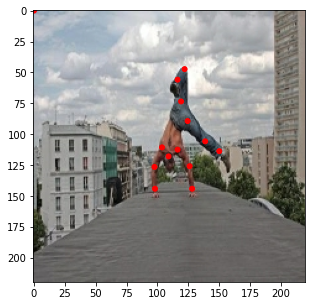

In [21]:
(test_img, valid_vec), joint_vector = next(test_data_iter)
print(joint_vector)

def plot_img_with_flatten_joints(img_arr, joints_vec_flatten, color_choice="red", radius_choice=2):
  fig, ax = plt.subplots(1)
  fig.set_size_inches(5, 5)
  ax.imshow(img_arr)
  for joints_number in range(joints_vec_flatten.shape[0] // 2):
    pos_x = joints_vec_flatten[2 * joints_number] * 220
    pos_y = joints_vec_flatten[2 * joints_number + 1] * 220
    ax.add_patch(Circle((pos_x,pos_y), color=color_choice, radius = radius_choice))

plot_img_with_flatten_joints(test_img, joint_vector)

In [49]:
test_data = test_data.batch(2048)
test_data_iter = iter(test_data)


(2, 220, 220, 3)


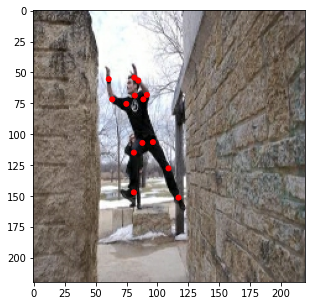

In [ ]:
(test_img, joints_valid),  joint_vector = next(test_data_iter)
print(test_img.shape)
plot_img_with_flatten_joints(test_img[0], joint_vector[0])

In [23]:
def euclidean_distance_loss(y_true, y_pred):
    #can I add joint_valid_info here??
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def cust_loss(y,y_pred):
  return tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(y, y_pred)), 1))

In [ ]:
input_tensor = tf.keras.Input(shape=image_input_shape)
input_joints_valid = tf.keras.Input(shape=(28))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(input_tensor)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x) 
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x) 
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x) 
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
x = tf.keras.layers.Dense(units=512, activation="relu")(x)
output_joints_vector = tf.keras.layers.Dense(units=28)(x)
output_joints_vector_valid = tf.keras.layers.multiply([input_joints_valid, output_joints_vector])
first_naive_model = tf.keras.Model(inputs=[input_tensor, input_joints_valid], outputs=output_joints_vector_valid)
first_naive_model.summary()
first_naive_model.compile(loss=cust_loss, optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 220, 220, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 110, 110, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
short_train_input, short_train_output = next(test_data_iter)
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if  epoch % 50 == 0 :
      loss = logs.get('loss')
      print("loss at epoch", epoch, loss)



#callback1 = MyCustomCallback()
learning_rate = 1e-3

newest_model = "drive/My Drive/humanpose-model/babyfeedmodel_1024.h5"
#loaded_naive_model = tf.keras.models.load_model(newest_model, custom_objects={'cust_loss': cust_loss})
#K.set_value(loaded_naive_model.optimizer.learning_rate, learning_rate)
history = loaded_naive_model.fit(short_train_input, short_train_output, verbose = 0, epochs=600, callbacks=[callback1])
#first_naive_model.save("drive/My Drive/humanpose-model/babyfeedmodel_1024.h5")

loss at epoch 0 0.7799872159957886
loss at epoch 50 0.060480158776044846
loss at epoch 100 0.012024544179439545


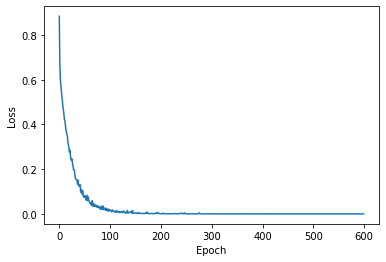

3.1852403026277898e-06


In [28]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
print((history.history["loss"])[-2])
loaded_naive_model.save("drive/My Drive/humanpose-model/babyfeedmodel_2048.h5")

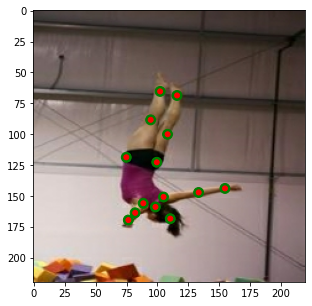

In [38]:
index = np.random.randint(0, 1024)
img = short_train_input[0][index]
ground_tr = short_train_output[index]
prediction =loaded_naive_model.predict(short_train_input)

plot_img_cmp(img, ground_tr, prediction[index])

In [30]:
def plot_img_cmp(img_arr, ground_tr,prediction,radius_choice=2):
  fig, ax = plt.subplots(1)
  fig.set_size_inches(5, 5)
  ax.imshow(img_arr)
  for joints_number in range(ground_tr.shape[0] // 2):
    pos_x = ground_tr[2 * joints_number] * 220
    pos_y = ground_tr[2 * joints_number + 1] * 220
    ax.add_patch(Circle((pos_x,pos_y), color="green", radius = 4))
    pos_x = prediction[2 * joints_number] * 220
    pos_y = prediction[2 * joints_number + 1] * 220
    ax.add_patch(Circle((pos_x,pos_y), color="red", radius = radius_choice))


In [ ]:
first_naive_model.save("drive/My Drive/humanpose-model/babyfeedmodel_128.h5")